In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
HotelReview = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/Hotel_Cleaned.csv")
HotelTrain = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/train_set.csv")
HotelTest = pd.read_csv("/content/drive/MyDrive/BAP Project/Datasets/Final Datasets/test_set.csv")

In [ ]:
HotelReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151319 entries, 0 to 151318
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Hotel               151319 non-null  object 
 1   Titles              151319 non-null  object 
 2   Reviews             151319 non-null  object 
 3   Dates               151319 non-null  object 
 4   Review_Rating       151319 non-null  int64  
 5   Travel_Type         151319 non-null  object 
 6   Hotel_Class         151319 non-null  float64
 7   No_of_Reviews       151319 non-null  int64  
 8   Rating              151319 non-null  float64
 9   Location            151319 non-null  float64
 10  Cleanliness         151319 non-null  float64
 11  Service             151319 non-null  float64
 12  Value               151319 non-null  float64
 13  Address             151319 non-null  object 
 14  FreeParking         151319 non-null  float64
 15  FreeWifi            151319 non-nul

In [ ]:
# Preprocess data for Regression
def data_preprocessing(df):
    df['Log_WordCount'] = np.log(df['Reviews_WordCount'])
    df = df.drop(['Hotel','Titles','Reviews','Dates','No_of_Reviews','Reviews_WordCount', 'Rating',
                  'Address','Sentiment_Pos','Sentiment_Neg','Sentiment_Neu','Sentiment','Year'], axis = 1)
    df = pd.get_dummies(df, columns = ['Travel_Type','Hotel_Class'], 
                        drop_first = True)
    return df

In [ ]:
def multiple_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()

    # GridSearchCV to find the best parameters
    params = {'fit_intercept': [True, False], 'positive': [True, False]}
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Fit the model
    model = LinearRegression(**grid_search.best_params_)
    model.fit(X_train, y_train)
    cdf = pd.DataFrame(model.coef_, X_train.columns, 
                       columns=['Coefficients'])
    print("Coefficient table:", cdf)

    # Predict on test set & calculate the R2, MAE, RMSE
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared =True)
    print("\nR2:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)

    # Plot Actual vs Predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values")
    plt.show()

    # Plot Residuals
    residuals = y_test - y_pred
    plt.scatter(y_test, residuals)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Actual")
    plt.show()


In [ ]:
def rfe_regression(X_train, X_test, y_train, y_test, no_features=5):

    estimator = LinearRegression()

    # Select top n features
    selector = RFE(estimator, n_features_to_select=no_features)
    selector.fit(X_train, y_train)

    selected_features = X_train.columns[selector.support_]
    print("Selected features:", selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # GridSearchCV to find the best parameters
    model = LinearRegression()
    params = {'fit_intercept': [True, False], 'positive': [True, False]}
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_selected, y_train)
    print("\nBest Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Fit the model
    model = LinearRegression(**grid_search.best_params_)
    model.fit(X_train_selected, y_train)
    cdf = pd.DataFrame(model.coef_, X_train_selected.columns, 
                       columns=['Coefficients'])
    print("Coefficient table:", cdf)

    # Predict on test set & calculate the R2, MAE, RMSE
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared =True)
    print("\nR2:", r2)
    print("MAE:", mae)
    print("RMSE:", rmse)

    # Plot Actual vs Predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values")
    plt.show()

    # Plot Residuals
    residuals = y_test - y_pred
    plt.scatter(y_test, residuals)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Actual")
    plt.show()


In [ ]:
def rfe_lasso_ridge_regression(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    
    # Feature Selection using RFE
    selector = RFE(estimator=model, step=1)
    selector.fit(X_train, y_train)
    selected_columns = X_train.columns[selector.support_]
    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]
    print("Selected Features:", selected_columns)

    ## Lasso
    # GridSearchCV to find the best parameters for Lasso
    lasso = Lasso()
    params = {'alpha': [0.01, 0.1, 1, 10]}
    grid_search_lasso = GridSearchCV(lasso, param_grid=params, cv=5, scoring='neg_mean_squared_error')
    grid_search_lasso.fit(X_train_selected, y_train)
    print("\nBest Parameters (Lasso):", grid_search_lasso.best_params_)
    print("Best Score (Lasso):", grid_search_lasso.best_score_)

    # Fit the Lasso model with the best parameters
    lasso_model = Lasso(**grid_search_lasso.best_params_)
    lasso_model.fit(X_train_selected, y_train)

    # Predict on test set & calculate the R2, MAE, RMSE for Lasso
    y_pred_lasso = lasso_model.predict(X_test_selected)
    r2_lasso = r2_score(y_test, y_pred_lasso)
    mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
    rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=True)
    print("\nLasso Results:")
    print("R2:", r2_lasso)
    print("MAE:", mae_lasso)
    print("RMSE:", rmse_lasso)

    # Plot Actual vs Predicted values for lasso
    plt.scatter(y_test, y_pred_lasso)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values (Lasso)")
    plt.show()

    # Plot Lasso Residuals
    residuals = y_test - y_pred_lasso
    plt.scatter(y_test, residuals)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Actual (Lasso)")
    plt.show()

    ## Ridge
    # GridSearchCV to find the best parameters for Ridge
    ridge = Ridge()
    params = {'alpha': [0.01, 0.1, 1, 10]}
    grid_search_ridge = GridSearchCV(ridge, param_grid=params, cv=5)
    grid_search_ridge.fit(X_train_selected, y_train)
    print("\nBest Parameters (Ridge):", grid_search_ridge.best_params_)
    print("Best Score (Ridge):", grid_search_ridge.best_score_)

    # Fit the Ridge model with the best parameters
    ridge_model = Ridge(**grid_search_ridge.best_params_)
    ridge_model.fit(X_train_selected, y_train)

    # Predict on test set & calculate the R2, MAE, RMSE for Ridge
    y_pred_ridge = ridge_model.predict(X_test_selected)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
    rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=True)
    print("\nRidge Results:")
    print("R2:", r2_ridge)
    print("MAE:", mae_ridge)
    print("RMSE:", rmse_ridge)

    # Plot Actual vs Predicted values for Ridge
    plt.scatter(y_test, y_pred_ridge)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted Values (Ridge)")
    plt.show()

    # Plot Ridge Residuals
    residuals = y_test - y_pred_ridge
    plt.scatter(y_test, residuals)
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Actual (Ridge)")
    plt.show()

Linear Regression
Best Parameters: {'fit_intercept': True, 'positive': False}
Best Score: -0.12145902919082774
Coefficient table:                       Coefficients
Review_Rating             0.267478
Location                  0.002662
Cleanliness              -0.005584
Service                   0.026039
Value                    -0.000756
FreeParking               0.009045
FreeWifi                 -0.014247
FreeBreakfast            -0.005057
Gym                      -0.029254
Pool                      0.011612
Restaurant               -0.015942
BarLounge                 0.011320
TV                        0.006058
EventFacilities           0.013474
RoomService              -0.017943
Log_WordCount             0.078847
Travel_Type_business      0.003767
Travel_Type_couple        0.022636
Travel_Type_family        0.003822
Travel_Type_friends       0.027738
Travel_Type_solo          0.017979
Hotel_Class_1.5           0.090957
Hotel_Class_2.0           0.046973
Hotel_Class_2.5           0.15

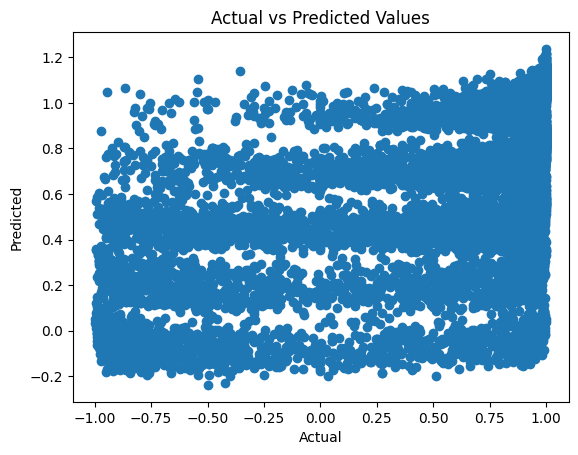

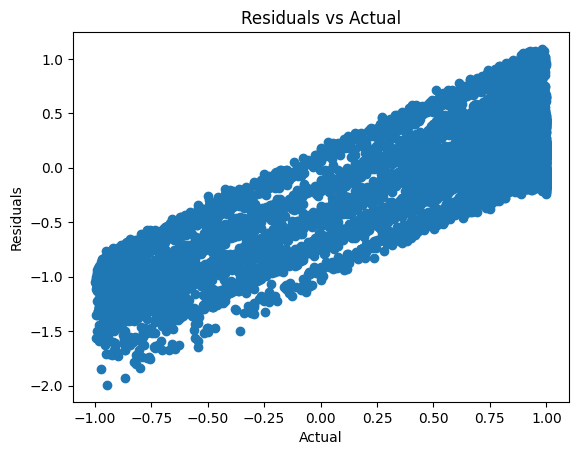

In [ ]:
HotelTrain_Processed = data_preprocessing(HotelTrain)
HotelTest_Processed = data_preprocessing(HotelTest)

y_train = HotelTrain_Processed['Sentiment_Compound']
x_train = HotelTrain_Processed.drop(['Sentiment_Compound'], axis = 1)
y_test = HotelTest_Processed['Sentiment_Compound']
x_test = HotelTest_Processed.drop(['Sentiment_Compound'], axis = 1)

print("Linear Regression")
multiple_regression(x_train, x_test, y_train, y_test)

Linear Regression with feature selection 

Selected features: Index(['Review_Rating', 'Service', 'Gym', 'Log_WordCount',
       'Travel_Type_friends', 'Hotel_Class_1.5', 'Hotel_Class_2.0',
       'Hotel_Class_2.5', 'Hotel_Class_3.0', 'Hotel_Class_4.0'],
      dtype='object')

Best Parameters: {'fit_intercept': True, 'positive': False}
Best Score: -0.12157611487909956
Coefficient table:                      Coefficients
Review_Rating            0.267871
Service                  0.020305
Gym                     -0.024037
Log_WordCount            0.079436
Travel_Type_friends      0.017825
Hotel_Class_1.5          0.072918
Hotel_Class_2.0          0.027004
Hotel_Class_2.5          0.130730
Hotel_Class_3.0          0.044250
Hotel_Class_4.0          0.026405

R2: 0.39163242971318823
MAE: 0.2217322702287059
RMSE: 0.12388218168636686


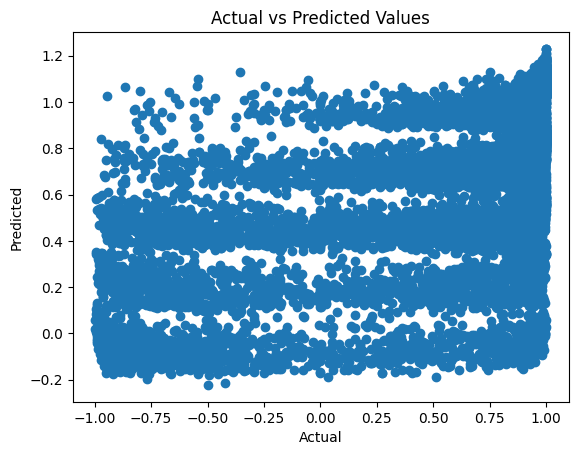

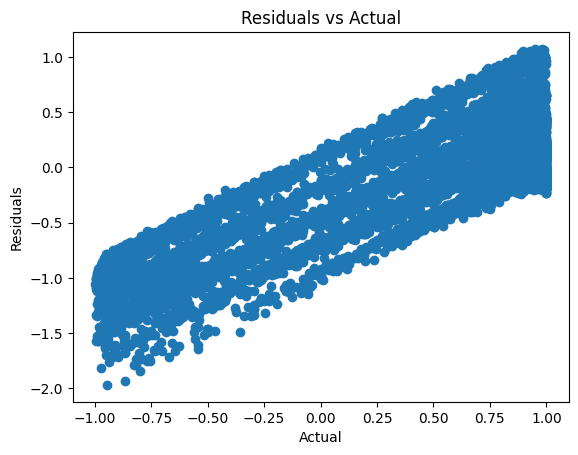

In [ ]:
print("Linear Regression with feature selection \n")

# Top 10 features
rfe_regression(x_train, x_test, y_train, y_test, 10)

Lasso Ridge Regression with feature selection 

Selected Features: Index(['Review_Rating', 'Service', 'Gym', 'Log_WordCount',
       'Travel_Type_couple', 'Travel_Type_friends', 'Hotel_Class_1.5',
       'Hotel_Class_2.0', 'Hotel_Class_2.5', 'Hotel_Class_3.0',
       'Hotel_Class_3.5', 'Hotel_Class_4.0', 'Hotel_Class_4.5',
       'Hotel_Class_5.0'],
      dtype='object')

Best Parameters (Lasso): {'alpha': 0.01}
Best Score (Lasso): -0.12243501743801737

Lasso Results:
R2: 0.3885213643473363
MAE: 0.21748595837218593
RMSE: 0.12451568942694045


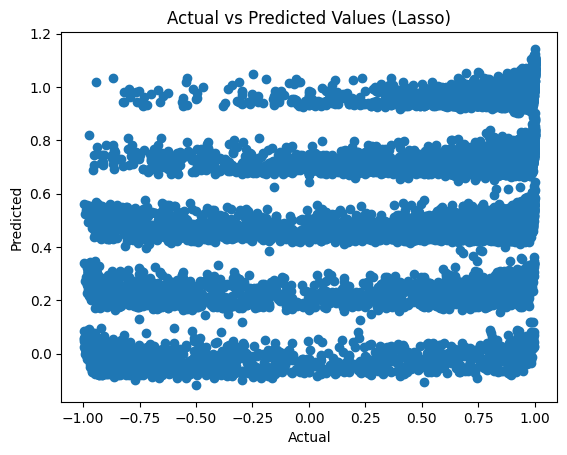

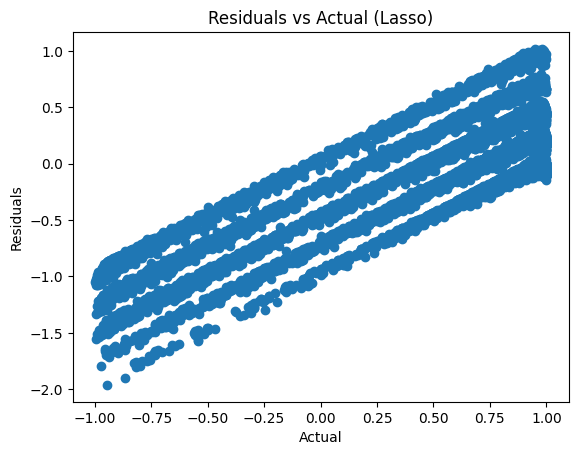


Best Parameters (Ridge): {'alpha': 10}
Best Score (Ridge): 0.4018393533368811

Ridge Results:
R2: 0.39183476876118817
MAE: 0.22178876966447159
RMSE: 0.12384097928845673


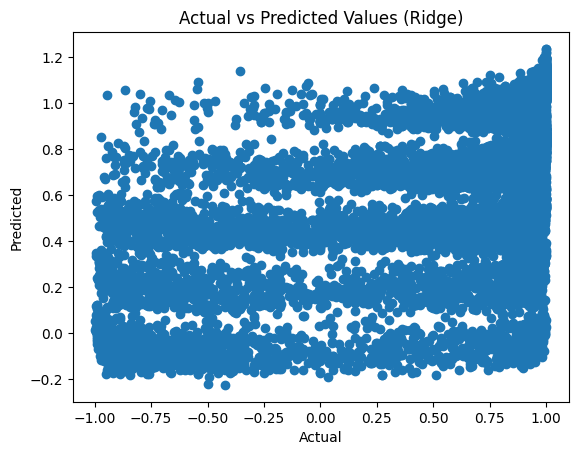

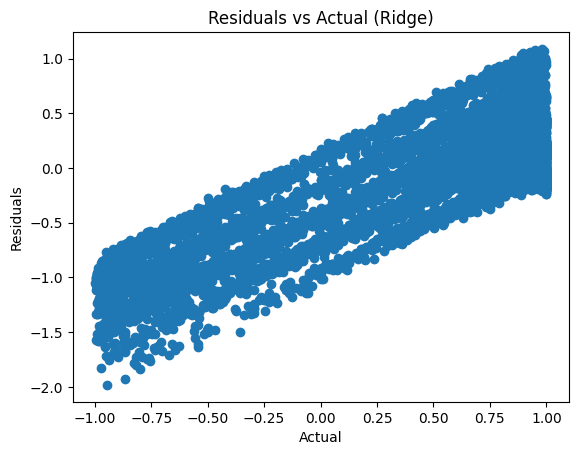

In [ ]:
print("Lasso Ridge Regression with feature selection \n")
rfe_lasso_ridge_regression(x_train, x_test, y_train, y_test)